In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, ProjectionCARE

Using TensorFlow backend.


In [2]:

(X,Y), (X_val,Y_val), axes = load_training_data('/data/u934/service_imagerie/v_kapoor/CurieTrainingDatasets/Drosophilla/IlastikDenoisingProjection.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 23040
number of validation images:	 2560
image size (3D):		 (26, 128, 128)
axes:				 SZYXC
channels in / out:		 1 / 1


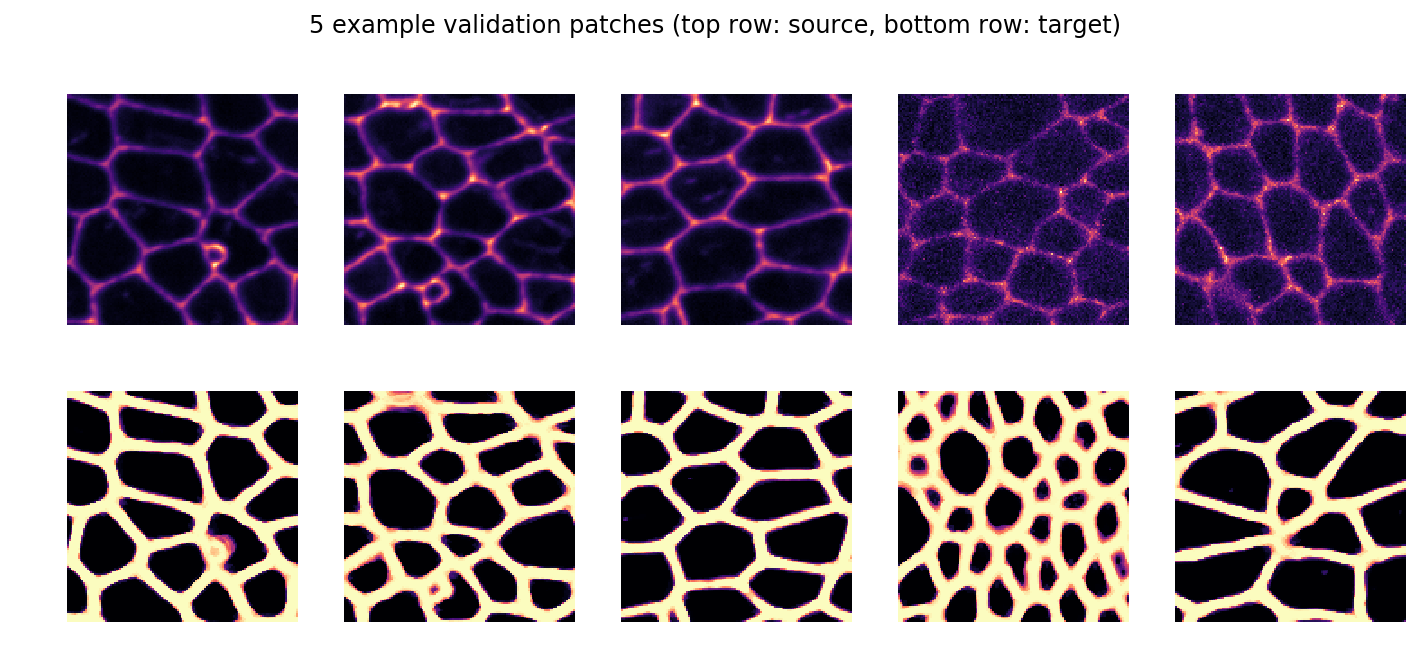

In [3]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [4]:
config = Config(axes, n_channel_in, n_channel_out, unet_n_depth=4,train_epochs= 50,train_steps_per_epoch = 400, train_batch_size = 16, train_reduce_lr={'patience': 5, 'factor': 0.5})
print(config)
vars(config)

Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=50, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'patience': 5, 'factor': 0.5}, train_steps_per_epoch=400, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=4, unet_n_first=32, unet_residual=True)


{'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 3,
 'probabilistic': False,
 'train_batch_size': 16,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 50,
 'train_learning_rate': 0.0004,
 'train_loss': 'mae',
 'train_reduce_lr': {'factor': 0.5, 'patience': 5},
 'train_steps_per_epoch': 400,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, None, 1),
 'unet_kern_size': 3,
 'unet_last_activation': 'linear',
 'unet_n_depth': 4,
 'unet_n_first': 32,
 'unet_residual': True}

In [5]:
model = ProjectionCARE(config, 'IlastikDrosophilaDenoisingProjection', basedir='/data/u934/service_imagerie/v_kapoor/CurieDeepLearningModels')

In [6]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/50
400/400 [==============================] - 850s 2s/step - loss: 0.3456 - mse: 0.2412 - mae: 0.3456 - val_loss: 0.3217 - val_mse: 0.2450 - val_mae: 0.3217
Epoch 2/50
400/400 [==============================] - 846s 2s/step - loss: 0.3192 - mse: 0.2456 - mae: 0.3192 - val_loss: 0.3155 - val_mse: 0.2415 - val_mae: 0.3155
Epoch 3/50
400/400 [==============================] - 846s 2s/step - loss: 0.3131 - mse: 0.2445 - mae: 0.3131 - val_loss: 0.3108 - val_mse: 0.2373 - val_mae: 0.3108
Epoch 4/50
400/400 [==============================] - 848s 2s/step - loss: 0.3074 - mse: 0.2416 - mae: 0.3074 - val_loss: 0.3117 - val_mse: 0.2506 - val_mae: 0.3117
Epoch 5/50
400/400 [==============================] - 850s 2s/step - loss: 0.3076 - mse: 0.2441 - mae: 0.3076 - val_loss: 0.3055 - val_mse: 0.2365 - val_mae: 0.3055
Epoch 6/50
400/400 [==============================] - 852s 2s/step - loss: 0.3028 - mse: 0.2409 - mae: 0.3028 - val_loss: 0.3055 - val_mse: 0.2399 - val_mae: 0.3055
Epoch 7/50

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


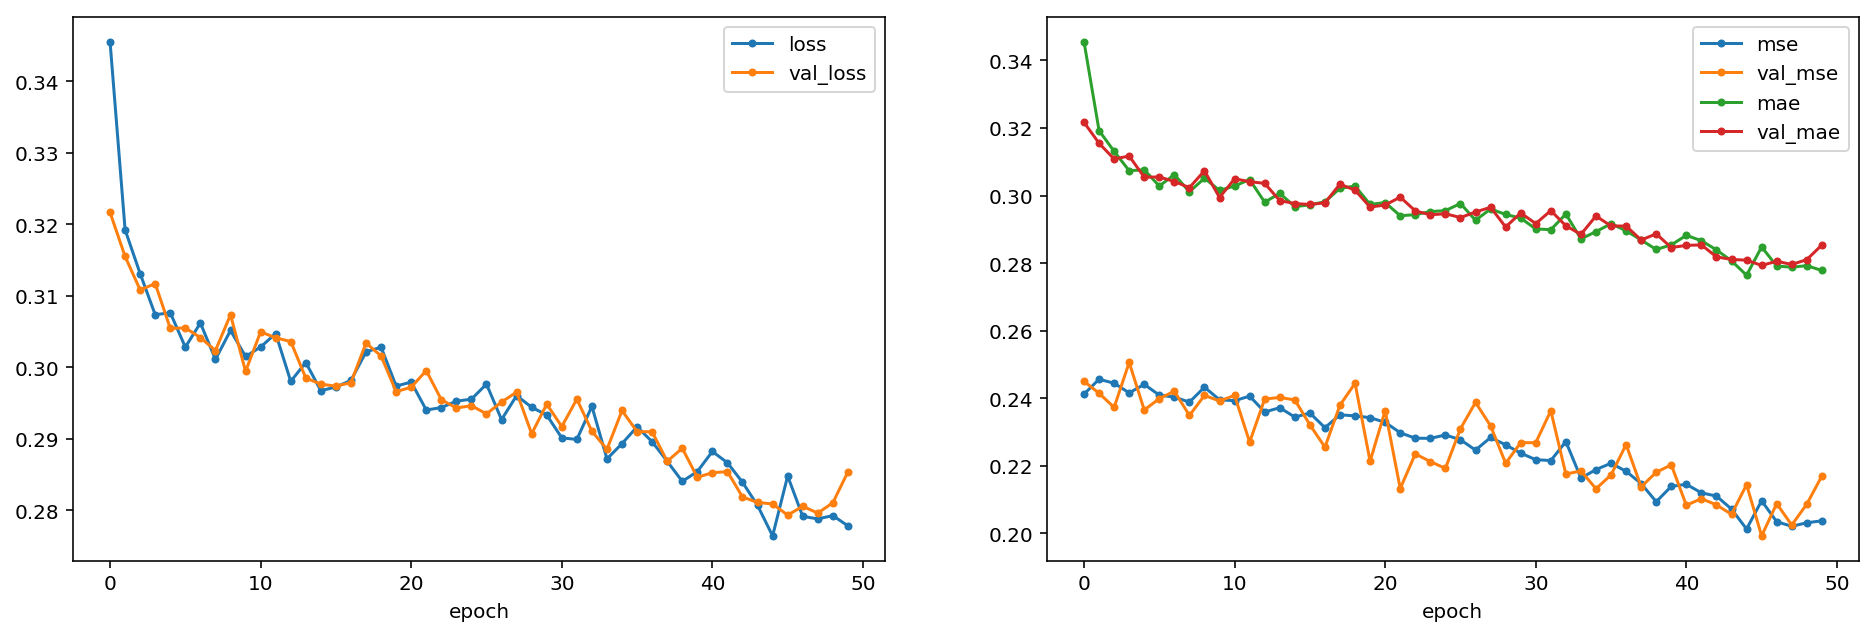

In [7]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

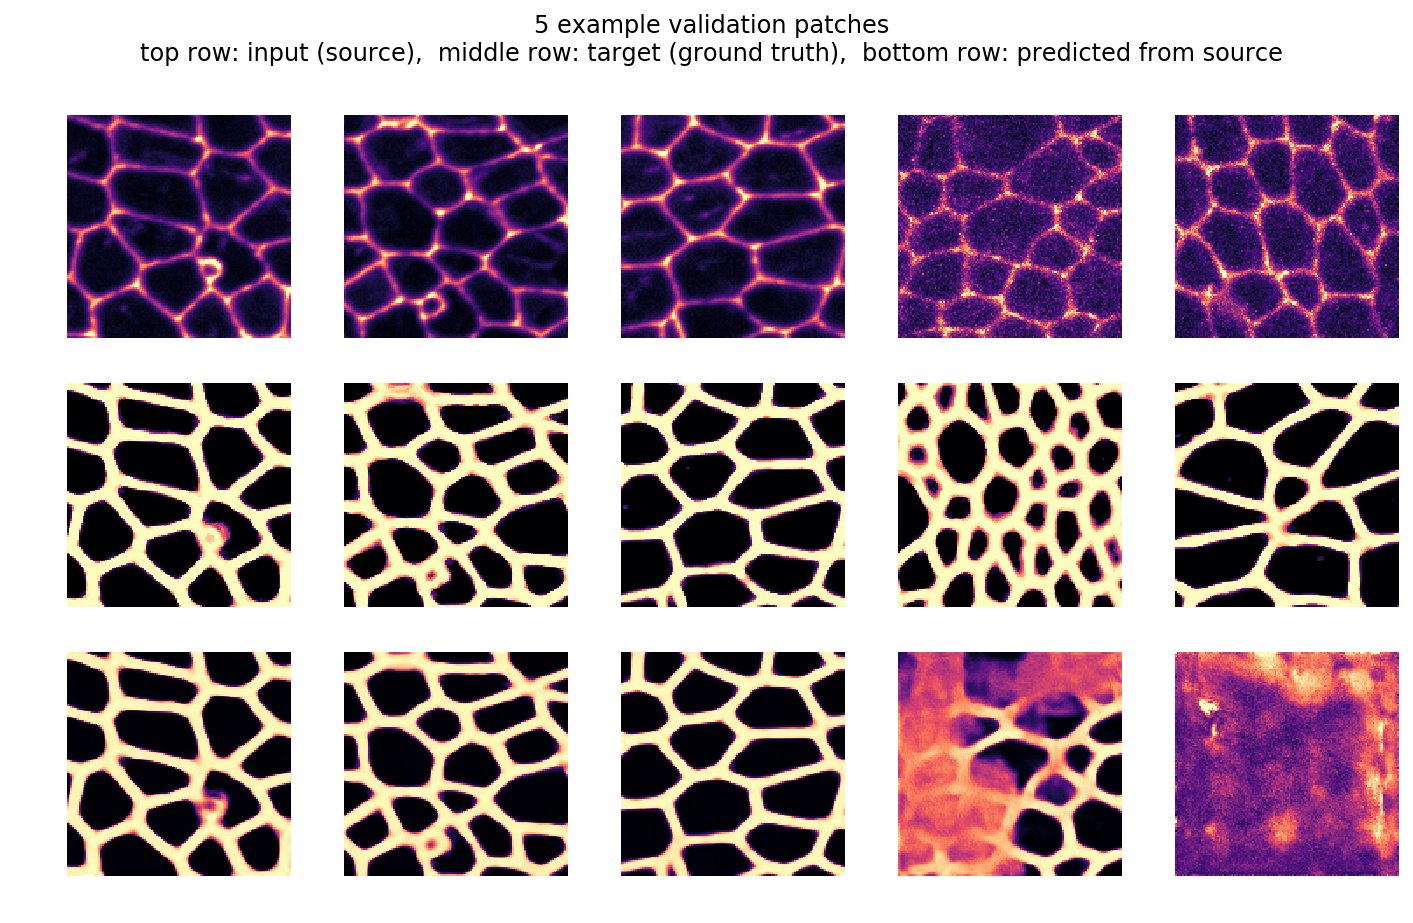

In [8]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

In [9]:
model.export_TF()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/tmp/tmp7i_q0cjf/model/saved_model.pb'

Model exported in TensorFlow's SavedModel format:
/data/u934/service_imagerie/v_kapoor/CurieDeepLearningModels/IlastikDrosophilaDenoisingProjection/TF_SavedModel.zip
